In [ ]:
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [ ]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Note: using Google CoLab


In [ ]:
if COLAB:
    !sudo apt-get install -y xvfb ffmpeg x11-utils
    !pip install -q 'gym==0.17.3'
    !pip install -q 'imageio==2.4.0'
    !pip install -q PILLOW
    !pip install -q 'pyglet==1.3.2'
    !pip install -q pyvirtualdisplay
    !pip install -q 'tf-agents==0.12.0'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
x11-utils is already the newest version (7.7+5build2).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gym 0.17.3 requires pyglet<=1.5.0,>=1.4.0, but you have pyglet 1.3.2 which is incompatible.


##Imports

In [ ]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import math
import numpy as np

import tensorflow as tf

from tf_agents.agents.ddpg import actor_network
from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.ddpg import ddpg_agent

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import policy_step
from tf_agents.utils import common

import gym
from gym import spaces
from gym.utils import seeding
from gym.envs.registration import register
import PIL.ImageDraw
import PIL.Image
from PIL import ImageFont

In [ ]:
# Set up a virtual display for rendering OpenAI gym environments.
vdisplay = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()


In [ ]:
def sequential_number_generator(start=50, step=1,bound=None):
  current = start
  while True:
      yield current
      current += step
      if bound is not None and current >= bound:
          current = start


# Create a generator instance
generator = sequential_number_generator(50,1,350+1)


#Create Environment

In [ ]:
class MEC_System(gym.Env):
  metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 1
    }

  STATE_ELEMENTS = 5
  STATES = ['channel_gain', 'task_size', 'comp_size','energy_harvested','battery_level']

  # H is exp distributed -> unit mean
  # task size -> uniform distribution 0-10MB
  # comp size -> unform
  # harvested energy -> uniform distribution -> max 1mJ

  STATE_CHANNEL_GAIN = 0
  STATE_TASK_SIZE = 1
  STATE_COMP_SIZE = 2
  STATE_ENERGY_HARVESTED = 3
  STATE_BATTERY_LEVEL = 4

  ACTION_ELEMENTS = 2
  ACTION_OFFLOAD = 0
  ACTION_TRANSMIT_POWER = 1


  NO_CPU_CYCLES_PER_UNIT = 8e5
  TRANSMIT_POWER = 1
  IDLE_POWER = 100e-3
  NOISE_POWER = 10e-12
  SPECTRAL_BANDWIDTH = 20e6
  CHANNEL_GAIN= 1

  MEC_COMP_CAPABILITY = 20e9
  LOCAL_COMP_CAPABILITY = 2.4e9
  CYCLES_PER_BIT = 737.5


  WEIGHT_DELAY = 0.9
  WEIGHT_ENERGY = 0.1

  min_data_size = 50e3 # 50kb
  max_data_size = 350e3
  min_comp_cycles = 200
  max_comp_cycles = 500 # cycles/bit
  min_battery_level = 0.0
  max_battery_level = 3.2e-3
  min_energy_harvested = 0
  max_energy_harvested = 1e-3


  def __init__(self):
    self.verbose = False
    self.viewer = None

    self.max_trans_power = 2 # watt

    self.action_space = spaces.Box(
        low=np.array([0.0, 0.0]),
        high=np.array([1.0, self.max_trans_power]),
        shape = (MEC_System.ACTION_ELEMENTS,),
        dtype = np.float32
    )

    self.observation_space = spaces.Box(
        low = np.array([0.0, MEC_System.min_data_size, MEC_System.min_comp_cycles, MEC_System.min_energy_harvested, MEC_System.min_battery_level]),
        high = np.array([50, MEC_System.max_data_size, MEC_System.max_comp_cycles, MEC_System.max_energy_harvested, MEC_System.max_battery_level] ),
        shape = (MEC_System.STATE_ELEMENTS,),
        dtype = np.float32
    )

    self.seed()
    self.reset()

    self.state_log = []

  def seed(self, seed=None):
      self.np_random, seed = seeding.np_random(seed)
      return [seed]

  def reset(self):
      self.state_log = []
      self.state = [0] * MEC_System.STATE_ELEMENTS
      self.last_action = [0] * MEC_System.ACTION_ELEMENTS

      self.state[MEC_System.STATE_CHANNEL_GAIN] = np.random.exponential(1)
      self.state[MEC_System.STATE_TASK_SIZE] = next(generator)  #np.random.uniform(MEC_System.min_data_size,MEC_System.max_data_size)
      self.state[MEC_System.STATE_COMP_SIZE] =  200 #np.random.uniform(MEC_System.min_comp_cycles,MEC_System.max_comp_cycles)
      self.state[MEC_System.STATE_ENERGY_HARVESTED] = np.random.uniform(MEC_System.min_energy_harvested, MEC_System.max_energy_harvested*1000)
      self.state[MEC_System.STATE_BATTERY_LEVEL] = np.random.uniform(MEC_System.min_battery_level, MEC_System.max_battery_level*1000)

      return np.array(self.state)

  def eval_action(self,action):
    partition_factor = action[MEC_System.ACTION_OFFLOAD]
    trans_power = action[MEC_System.ACTION_TRANSMIT_POWER]

    if partition_factor < 1e-2:
      partition_factor = 0
      trans_power = 0

    return partition_factor, trans_power


  def step(self, action):
      self.last_action = action
      channel_gain = self.state[MEC_System.STATE_CHANNEL_GAIN]
      task_size = self.state[MEC_System.STATE_TASK_SIZE]
      comp_size = self.state[MEC_System.STATE_COMP_SIZE]
      energy_harvested = self.state[MEC_System.STATE_ENERGY_HARVESTED]
      battery = self.state[MEC_System.STATE_BATTERY_LEVEL]

      partition_factor, trans_power = self.eval_action(action)
      trans_rate = MEC_System.SPECTRAL_BANDWIDTH*math.log2(1+ \
                        ((trans_power*channel_gain)/MEC_System.NOISE_POWER))
      print(partition_factor)
      if self.verbose:
        print("*******start step*****")
        print("ACTIONS")
        print(f"partition factor : {partition_factor} ##   trans_power : {trans_power}")
        print("")
        print(f"STATE")
        print(f"trans power {trans_power}")
        print(f"trans rate : {trans_rate}")
        print(f"task size : {task_size}bits ## comp size : {comp_size}cycles/bit")
        print(f'channel gain : {channel_gain}')
        print(f'energy harvested : {energy_harvested}')
        print(f'battery level : {battery}\n')

      local_time_delay = task_size* comp_size * (1-partition_factor)/MEC_System.LOCAL_COMP_CAPABILITY
      if trans_rate == 0:
          offload_trans_time = 0
      else :
        offload_trans_time = task_size*partition_factor /trans_rate
      offload_comp_time = task_size*comp_size * partition_factor/ MEC_System.MEC_COMP_CAPABILITY
      total_offload_time = (offload_trans_time + offload_comp_time)


      K = 10e-27
      energy_local = local_time_delay* (K)*(MEC_System.LOCAL_COMP_CAPABILITY**3)/10
      energy_offload = offload_trans_time*trans_power*1000

      total_delay = max(local_time_delay, total_offload_time)
      total_energy = energy_local + energy_offload



      cost = MEC_System.WEIGHT_DELAY * total_delay + MEC_System.WEIGHT_ENERGY * total_energy

      done = True

      if total_energy < energy_harvested+battery :
         reward = -cost
      else:
        reward = -cost -4


      self.state_log.append(self.state + [cost,
                                          total_energy,
                                          total_delay])
      # self.state[5]

      if self.verbose:
        print(f"local energy : {energy_local}")
        print(f"energy_offload : {energy_offload}")
        print(f"l-delay : {local_time_delay}")
        print(f"offload delay : {total_offload_time}")
        print(f"Total energy : {total_energy}")
        print(total_energy < energy_harvested+battery)
        print(f"reward: {reward}")
        print("******** END *********\n")

      locals = self.local_only()
      offloads = self.offload_only()

      return self.state, reward*10, done, {'cost' : cost, 'energy':total_energy, 'delay':total_delay,
                                          'local_only': locals, 'offload_only':offloads}

  def close(self):
        pass

  def local_only(self):
      channel_gain = self.state[MEC_System.STATE_CHANNEL_GAIN]
      task_size = self.state[MEC_System.STATE_TASK_SIZE]
      comp_size = self.state[MEC_System.STATE_COMP_SIZE]
      energy_harvested = self.state[MEC_System.STATE_ENERGY_HARVESTED]
      battery = self.state[MEC_System.STATE_BATTERY_LEVEL]

      partition_factor = 0
      trans_power = 0

      local_time_delay = task_size* comp_size * (1-partition_factor)/MEC_System.LOCAL_COMP_CAPABILITY


      K = 10e-27
      energy_local = local_time_delay* (K)*(MEC_System.LOCAL_COMP_CAPABILITY**3)/10

      total_energy = energy_local


      cost = MEC_System.WEIGHT_DELAY * local_time_delay + MEC_System.WEIGHT_ENERGY * total_energy

      return {'delay':local_time_delay, 'cost':cost}


  def offload_only(self):
    channel_gain = self.state[MEC_System.STATE_CHANNEL_GAIN]
    task_size = self.state[MEC_System.STATE_TASK_SIZE]
    comp_size = self.state[MEC_System.STATE_COMP_SIZE]
    energy_harvested = self.state[MEC_System.STATE_ENERGY_HARVESTED]
    battery = self.state[MEC_System.STATE_BATTERY_LEVEL]

    partition_factor = 1
    trans_power = 0.8

    trans_rate = MEC_System.SPECTRAL_BANDWIDTH*math.log2(1+ \
                      ((trans_power*channel_gain)/MEC_System.NOISE_POWER))

    local_time_delay = 0
    if trans_rate == 0:
        offload_trans_time = 0
    else :
      offload_trans_time = task_size*partition_factor /trans_rate
    offload_comp_time = task_size*comp_size * partition_factor/ MEC_System.MEC_COMP_CAPABILITY
    total_offload_time = (offload_trans_time + offload_comp_time)


    K = 10e-27
    energy_local = 0
    energy_offload = offload_trans_time*trans_power*1000

    total_delay = max(local_time_delay, total_offload_time)
    total_energy = energy_local + energy_offload

    cost = MEC_System.WEIGHT_DELAY * total_delay + MEC_System.WEIGHT_ENERGY * total_energy

    return {'delay':total_delay, 'cost':cost}



## Register Environment

In [ ]:
register(
    id='MEC_env-v12',
    entry_point=f'{__name__}:MEC_System',
)

/usr/local/lib/python3.10/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0.7
{'cost': 8.822196328356424e-06, 'energy': 7.652196328356422e-05, 'delay': 1.3000000000000003e-06, 'local_only': {'delay': 4.333333333333333e-06, 'cost': 9.8904e-06}, 'offload_only': {'delay': 6.045192857255706e-07, 'cost': 7.305610215198662e-06}}
0.7
{'cost': 8.048109247510662e-06, 'energy': 6.855609247510662e-05, 'delay': 1.3250000000000002e-06, 'local_only': {'delay': 4.416666666666667e-06, 'cost': 1.0080600000000001e-05}, 'offload_only': {'delay': 6.024016761202253e-07, 'cost': 6.334295598126225e-06}}
0.7
{'cost': 8.031990577019494e-06, 'energy': 6.816990577019494e-05, 'delay': 1.3500000000000002e-06, 'local_only': {'delay': 4.5e-06, 'cost': 1.02708e-05}, 'offload_only': {'delay': 6.113264851327868e-07, 'cost': 6.256312647242456e-06}}
0.7
{'cost': 8.607555214884184e-06, 'energy': 7.370055214884184e-05, 'delay': 1.3750000000000002e-06, 'local_only': {'delay': 4.583333333333333e-06, 'cost': 1.0461e-05}, 'offload_only': {'delay': 6.288534527805508e-07, 'cost': 6.874244329946556e-06

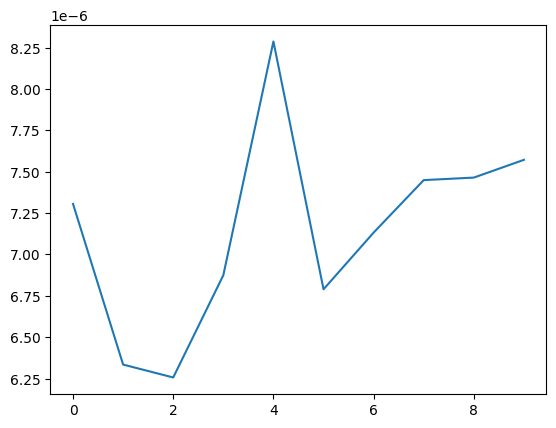

In [ ]:
import random

env_name = "MEC_env-v12"
env = gym.make(env_name)

cost = []
env.reset()
done = False
# env.verbose = True
episodes = 10
log_interval = 5000
returns = []
lo = []

for episode in range(1,episodes+1):
  state = env.reset()
  done=False
  score=0

  while not done:
    # action = random.choice([0,1])
    state, reward, done, info = env.step([0.7, 1])
    score+=reward
    print(info)
    local = info['offload_only']['cost']
    lo.append(local)
    # env.render()
    log = env.state_log
        # print(log)
    cost.append(log[0][6])

    if episode % log_interval == 0:
        print(f"Episode {episode}, Score : {score}")
        returns.append(score)
        log = env.state_log
        # print(log)
        cost.append(log[0][6])


    # if step % eval_interval == 0:
    #     avg_return = compute_avg_return(eval_env, tf_agent.policy,
    #                                     num_eval_episodes)
    #     print('step = {0}: Average Return = {1}'.format(step, avg_return))
    #     returns.append(avg_return)

env.close()
plt.plot(lo)
plt.show()


In [ ]:
# iterations = range(0, episodes , log_interval)
# plt.plot(iterations, cost)
# plt.ylabel('Average Return')
# plt.xlabel('Iterations')
# plt.ylim(top=25)

## Hyperparameters

In [ ]:
# How long should training run?
num_iterations = 20000
# How often should the program provide an update.
log_interval = 500
summary_interval=1000,
summaries_flush_secs=10,
debug_summaries=False,
summarize_grads_and_vars=False,
eval_metrics_callback=None,
# How many initial random steps, before training start, to
# collect initial data.
initial_collect_steps = 1000
# How many steps should we run each iteration to collect
# data from.
collect_steps_per_iteration = 50
# How much data should we store for training examples.
replay_buffer_max_length = 100000

batch_size = 64

# How many episodes should the program use for each evaluation.
num_eval_episodes = 350
# How often should an evaluation occur.
eval_interval = 500

#Instantiate the Environment

load environment. Since the environment is registered with the TF-Agents, we can load the enviroment  by the name "MEC_env_v0"

In [ ]:
env_name = 'MEC_env-v12'
env = suite_gym.load(env_name)

Instantiate two environments : one for training and one for evaluation


In [ ]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


In [ ]:
train_env.pyenv.get_info()

array([None], dtype=object)

# Create Critic and Actor Neural Networks

In [ ]:
actor_fc_layers = (400, 300)
critic_obs_fc_layers = (400,)
critic_action_fc_layers = None
critic_joint_fc_layers = (300,)
#collection params for buffer
ou_stddev = 0.2
ou_damping = 0.15
target_update_tau = 0.05
target_update_period = 5
dqda_clipping = None
td_errors_loss_fn = tf.compat.v1.losses.huber_loss
gamma = 0.995
reward_scale_factor = 1.0
gradient_clipping = None

actor_learning_rate = 1e-4
critic_learning_rate = 1e-3
debug_summaries = False
summarize_grads_and_vars = False
num_parallel_environments=1
global_step = tf.compat.v1.train.get_or_create_global_step()


actor_net = actor_network.ActorNetwork(
    train_env.time_step_spec().observation,
    train_env.action_spec(),
    fc_layer_params=actor_fc_layers,
)

critic_net_input_specs = (train_env.time_step_spec().observation,
                          train_env.action_spec())

critic_net = critic_network.CriticNetwork(
    critic_net_input_specs,
    observation_fc_layer_params=critic_obs_fc_layers,
    action_fc_layer_params=critic_action_fc_layers,
    joint_fc_layer_params=critic_joint_fc_layers,
)

tf_agent = ddpg_agent.DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    ou_stddev=ou_stddev,
    ou_damping=ou_damping,
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    dqda_clipping=dqda_clipping,
    td_errors_loss_fn=td_errors_loss_fn,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    debug_summaries=debug_summaries,
    summarize_grads_and_vars=summarize_grads_and_vars,
    train_step_counter=global_step)
tf_agent.initialize()


#Metrics and Evaluation

In [ ]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  total_delay = 0.0
  total_cost =0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    delay_ep = 0.0
    cost_ep = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
      x = environment.pyenv.get_info()
      delay_ep = x['delay']
      cost_ep = x['cost']
    total_return += episode_return
    total_delay += delay_ep
    total_cost += cost_ep

  avg_delay = total_delay/num_episodes
  avg_return = total_return / num_episodes
  avg_cost = total_cost/ num_episodes

  print(f"ret: {avg_return}; delay: {avg_delay}")


  return avg_return.numpy()[0], avg_delay[0], avg_cost[0]

#Data Collection
In order to populate the replay buffer, a random policy is followed in the environemnt for a few steps

In [ ]:

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=tf_agent.collect_data_spec,
        batch_size=train_env.batch_size,
        max_length=100000)

replay_observer = [replay_buffer.add_batch]

dataset = replay_buffer.as_dataset(
            num_parallel_calls=3,
            sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

train_metrics = [
            tf_metrics.NumberOfEpisodes(),
            tf_metrics.EnvironmentSteps(),
            tf_metrics.AverageReturnMetric(),
]

eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

driver = dynamic_step_driver.DynamicStepDriver(
            train_env,
            collect_policy,
            observers=replay_observer + train_metrics,
    num_steps=1)

avg_return, delay, cost = compute_avg_return(eval_env, tf_agent.policy,
                                num_eval_episodes)
returns = [avg_return]
delays = [delay]
costs = [cost]

episode_len = []
loss = []

## Train the agent

In [ ]:

final_time_step, policy_state = driver.run()

for i in range(num_iterations):
    final_time_step, _ = driver.run(final_time_step, policy_state)

    experience, _ = next(iterator)
    train_loss = tf_agent.train(experience=experience)
    step = tf_agent.train_step_counter.numpy()

    train_env.current_time_step

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))
        loss.append(train_loss.loss)

        # print('Average episode length: {}'.format(train_metrics[3].result().numpy()))

    if step % eval_interval== 0:
        avg_return,delay,cost = compute_avg_return(eval_env, tf_agent.policy, 200)
        returns.append(avg_return)
        delays.append(delay)
        costs.append(cost)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))

plt.plot(loss)
plt.ylabel("Average TotalLoss")
plt.xlabel("Number of Episodes")
plt.show()


##Display the Cost

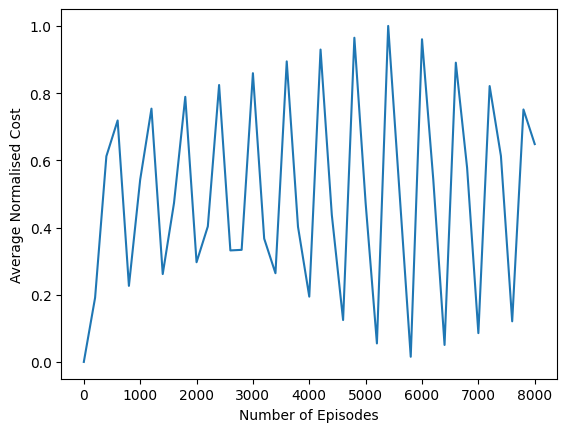

In [ ]:
x = returns
# x_norm = (x-np.min(x))/(np.max(x)-np.min(x))
# x_val = [i*200 for i in range(len(returns))]
# plt.plot(x_val,x_norm)
# plt.ylabel("Average Normalised Reward")
# plt.xlabel("Number of Episodes")
# plt.show()

z =[-1*i for i in returns]
# print(returns)
z_norm = (z-np.min(z))/(np.max(z)-np.min(z))
x_val = [i*200 for i in range(len(returns))]
plt.plot(x_val,z_norm)
plt.ylabel("Average Normalised Cost")
plt.xlabel("Number of Episodes")
plt.show()

## Compare different offload approaches

In [ ]:
generator = sequential_number_generator(50,1,350+1)

c = [] #returns
c_l = []
c_o = []

d = []
d_l = []
d_o = []

sum_c_l = 0.0
sum_c_o = 0.0
sum_c = 0.0

sum_d = 0.0
sum_d_l = 0.0
sum_d_o = 0.0
step = 1

for i in range(300+1):
  # final_time_step, _ = driver.run(final_time_step, policy_state)
  # train_loss = tf_agent.train(experience=experience)

    time_step = eval_env.reset()
    num_episodes = 50

    while not time_step.is_last():
      action_step = tf_agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      # episode_return += time_step.reward
      x = eval_env.pyenv.get_info()
      delay_ep = x['delay']
      cost_ep = x['cost']
      delay_l_ep = x['local_only']['delay']
      cost_l_ep = x['local_only']['cost']
      delay_o_ep = x['offload_only']['delay']
      cost_o_ep = x['offload_only']['cost']
    sum_c_l = cost_l_ep
    sum_c_o = cost_o_ep
    sum_c = cost_ep

    sum_d = delay_ep
    sum_d_l = delay_l_ep
    sum_d_o = delay_o_ep
    step+=1
      # print('Average episode length: {}'.format(train_metrics[3].result().numpy()))

    if step % 50== 0:
        print(step)
        avg_delay = sum_d/num_episodes
        avg_delay_off = sum_d_o/num_episodes
        avg_delay_loc = sum_d_l/num_episodes

        avg_cost = sum_c/ num_episodes
        avg_cost_off = sum_c_o/num_episodes
        avg_cost_loc = sum_c_l/num_episodes

        # return avg_return.numpy()[0], avg_delay[0], avg_cost[0]
        c.append(avg_cost[0])
        c_l.append(avg_cost_loc[0])
        c_o.append(avg_cost_off[0])

        d.append(avg_delay[0])
        d_l.append(avg_delay_loc[0])
        d_o.append(avg_delay_off[0])

        sum_c_l = 0.0
        sum_c_o = 0.0
        sum_c = 0.0

        sum_d = 0.0
        sum_d_l = 0.0
        sum_d_o = 0.0


[6.09811403e-07 8.79064045e-07 7.30842092e-07 1.07837666e-06
 1.37935037e-06 1.64945769e-06]


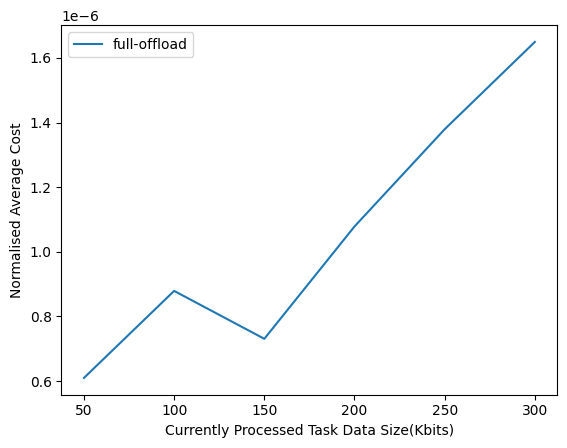

In [ ]:
x =[50*i for i in range(1,len(c)+1)]

c = z
z_norm = (z-np.min(z))/(np.max(z)-np.min(z))
# plt.plot(x,c)

z = c_l_
z_norm = (z-np.min(z))/(np.max(z)-np.min(z))
plt.plot(x, z)

# z = c_o
print(c)
# z= [i*0.8 for i in c]

z_norm = (z-np.min(z))/(np.max(z)-np.min(z))
# plt.plot(x,c_o)

plt.legend(["full-offload", "full-local",'DDPG'], loc ="upper left")

plt.xlabel('Currently Processed Task Data Size(Kbits)')
plt.ylabel('Normalised Average Cost')
plt.show()
